# Proyek Analisis Data: [Input Nama Dataset]
- **Nama:** Afiana Nurani
- **Email:** anaafiana2603@gmail.com
- **ID Dicoding:** afiananr

## Menentukan Pertanyaan Bisnis

- Pertanyaan 1 : Kategori produk apa yang memiliki total penjualan (revenue) tertinggi dan terendah pada tahun 2017 hingga 2018?
- Pertanyaan 2 : Bagaimana persebaran geografis pelanggan (customer state) yang paling banyak melakukan transaksi?


## Import Semua Packages/Library yang Digunakan

In [49]:
!pip install streamlit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import streamlit as st
from datetime import datetime

sns.set(style='dark')

## Data Wrangling

### Gathering Data

In [50]:
# Memuat dataset
customers_df = pd.read_csv("data/customers_dataset.csv")
orders_df = pd.read_csv("data/orders_dataset.csv")
items_df = pd.read_csv("data/order_items_dataset.csv")
products_df = pd.read_csv("data/products_dataset.csv")
category_df = pd.read_csv("data/product_category_name_translation.csv")

# Menampilkan 5 baris pertama dari salah satu dataframe
orders_df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


**Insight:**
- Semua dataset yang diperlukan (9 file CSV) telah berhasil dimuat ke dalam DataFrame.

### Assessing Data

In [51]:
# --- 1. Assessing orders_df ---
print("=== Assessing orders_df ===")
print(orders_df.isna().sum())
print("Jumlah duplikasi:", orders_df.duplicated().sum())
orders_df.info()

# --- 2. Assessing customers_df ---
print("\n=== Assessing customers_df ===")
print(customers_df.isna().sum())
print("Jumlah duplikasi:", customers_df.duplicated().sum())
# Penting: Cek apakah customer_unique_id ada yang duplikat (satu orang belanja berkali-kali)
print("Jumlah ID pelanggan unik:", customers_df['customer_unique_id'].nunique())

# --- 3. Assessing products_df ---
print("\n=== Assessing products_df ===")
print(products_df.isna().sum())
print("Jumlah duplikasi:", products_df.duplicated().sum())

# --- 4. Assessing items_df ---
print("\n=== Assessing items_df ===")
print(items_df.isna().sum())
# Menggunakan describe untuk mengecek anomali harga (outliers)
print(items_df.describe())

=== Assessing orders_df ===
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64
Jumlah duplikasi: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  obj

**Insight:**
- **orders_df**: Seluruh kolom pada orders_df saat ini bertipe object (string). Kolom-kolom yang berisi informasi waktu seperti order_purchase_timestamp hingga order_estimated_delivery_date seharusnya dikonversi menjadi tipe data datetime agar bisa digunakan untuk analisis tren waktu. Terdapat data kosong (missing values) pada kolom order_approved_at (160), order_delivered_carrier_date (1783), dan order_delivered_customer_date (2965). Hal ini kemungkinan terjadi karena adanya pesanan yang dibatalkan (canceled) atau belum terkirim pada saat data diambil.
- **customers_df**: Data pelanggan sangat bersih dengan 0 missing values dan 0 duplikasi. Terdapat 96.096 pelanggan unik, yang berarti ada sebagian kecil pelanggan yang melakukan pemesanan lebih dari satu kali.
- **products_df**:Ditemukan 610 data kosong pada kolom product_category_name. Hal ini perlu ditangani agar saat penggabungan data, produk-produk tersebut tidak hilang atau terbuang dari analisis kategori.
- Secara statistik, data harga (price) dan ongkos kirim (freight_value) terlihat masuk akal dengan nilai minimum harga sebesar 0.85 dan ongkir 0.00 (mungkin gratis ongkir). Tidak ditemukan adanya nilai negatif yang mencurigakan.

### Cleaning Data

In [52]:
# 1. Mengonversi kolom waktu pada orders_df menjadi tipe datetime
datetime_columns = [
    "order_purchase_timestamp",
    "order_approved_at",
    "order_delivered_carrier_date",
    "order_delivered_customer_date",
    "order_estimated_delivery_date"
]

for column in datetime_columns:
    orders_df[column] = pd.to_datetime(orders_df[column])

# 2. Menangani missing values pada product_category_name
# Isi dengan 'others' agar produk tidak hilang saat di-merge
products_df['product_category_name'] = products_df['product_category_name'].fillna('others')

# Mengisi sisa missing values pada kolom deskripsi produk dengan 0 atau median
products_df['product_name_lenght'] = products_df['product_name_lenght'].fillna(0)
products_df['product_description_lenght'] = products_df['product_description_lenght'].fillna(0)
products_df['product_photos_qty'] = products_df['product_photos_qty'].fillna(0)

# 3. Menghapus baris dengan spesifikasi fisik yang kosong (hanya 2 baris)
products_df.dropna(subset=['product_weight_g'], inplace=True)

# 4. Memastikan kembali hasil pembersihan
print("Info Orders setelah Cleaning:")
orders_df.info()
print("\nMissing Values Products setelah Cleaning:")
print(products_df.isna().sum())

Info Orders setelah Cleaning:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.1+ MB

Missing Values Products setelah Cleaning:
product_id                    0
product_category_name         0
product_name_lenght       

**Insight:**
- Seluruh kolom yang berkaitan dengan alur transaksi pada orders_df (dari pemesanan hingga estimasi pengiriman) telah dikonversi menjadi tipe data datetime64. Hal ini menjamin akurasi saat kita melakukan analisis tren waktu.
- Penanganan missing values pada kategori produk dilakukan dengan pengisian nilai "others".
- Kolom-kolom deskriptif seperti panjang nama, deskripsi, dan jumlah foto produk yang kosong telah diisi dengan nilai 0. Meskipun kolom ini tidak menjadi fokus utama dalam menjawab pertanyaan bisnis, imputasi ini memastikan tidak ada baris yang hilang secara tidak sengaja saat melakukan operasi pada dataset.
- Penghapusan baris yang tidak memiliki spesifikasi fisik produk (berat dan dimensi) dilakukan karena jumlahnya sangat sedikit (hanya 2 baris) dan tidak signifikan terhadap total populasi data, namun kehadirannya bisa mengganggu konsistensi data fisik produk.

## Exploratory Data Analysis (EDA)

### Explore Exploration of All Data (Merging)

In [53]:
# 1. Merge orders_df dengan items_df (Primary key: order_id)
main_df = pd.merge(
    left=orders_df,
    right=items_df,
    how="left",
    on="order_id"
)

# 2. Merge dengan customers_df (Primary key: customer_id)
main_df = pd.merge(
    left=main_df,
    right=customers_df,
    how="left",
    on="customer_id"
)

# 3. Merge dengan products_df (Primary key: product_id)
main_df = pd.merge(
    left=main_df,
    right=products_df,
    how="left",
    on="product_id"
)

# 4. Merge dengan category_df untuk terjemahan nama kategori
main_df = pd.merge(
    left=main_df,
    right=category_df,
    how="left",
    on="product_category_name"
)

# Kita ambil kolom yang dibutuhkan Dashboard: RFM, Loyalty, State, dan Category
columns_to_keep = [
    'order_id',
    'customer_id',
    'customer_unique_id',
    'order_purchase_timestamp',
    'product_category_name_english',
    'price',
    'customer_state'
]

# Filter main_df agar isinya cuma kolom di atas
main_df_small = main_df[columns_to_keep]

# 3. SAVE JADI FILE BARU (Pasti Ringan & Aman buat GitHub)
main_df_small.to_csv("main_data.csv", index=False)

print("BERHASIL! File 'main_data.csv' sudah siap.")
main_df_small.head()

# Melihat 5 baris pertama hasil gabungan
main_df.head()

BERHASIL! File 'main_data.csv' sudah siap.


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,customer_state,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1.0,87285b34884572647811a353c7ac498a,...,SP,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1.0,595fac2a385ac33a80bd5114aec74eb8,...,BA,perfumaria,29.0,178.0,1.0,400.0,19.0,13.0,19.0,perfumery
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,1.0,aa4383b373c6aca5d8797843e5594415,...,GO,automotivo,46.0,232.0,1.0,420.0,24.0,19.0,21.0,auto
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,...,RN,pet_shop,59.0,468.0,3.0,450.0,30.0,10.0,20.0,pet_shop
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,1.0,65266b2da20d04dbe00c5c2d3bb7859e,...,SP,papelaria,38.0,316.0,4.0,250.0,51.0,15.0,15.0,stationery


**Insight:**
- Seluruh informasi dari tabel pesanan, item, pelanggan, dan detail produk kini telah menyatu dalam satu DataFrame bernama main_df.
- Kolom product_category_name telah terisi, sehingga kita bisa melakukan analisis kategori produk.
- Adanya kolom customer_state memungkinkan kita untuk melakukan Geospatial Analysis guna memetakan provinsi mana yang memiliki basis pelanggan paling aktif.
- Dengan kolom timestamp yang sudah bersih, kita memiliki data lengkap dari saat pesanan dibuat (order_purchase_timestamp) hingga sampai ke tangan pelanggan (order_delivered_customer_date), yang sangat berguna untuk mengukur performa pengiriman.

### Exploration of Product Performance (2017-2018)

In [54]:
# Filter data untuk tahun 2017 - 2018
main_df['order_purchase_timestamp'] = pd.to_datetime(main_df['order_purchase_timestamp'])
filtered_df = main_df[(main_df['order_purchase_timestamp'].dt.year >= 2017) &
                       (main_df['order_purchase_timestamp'].dt.year <= 2018)]

# Mengelompokkan berdasarkan kategori produk
category_revenue_df = filtered_df.groupby("product_category_name_english").price.sum().sort_values(ascending=False).reset_index()

# Menampilkan hasil
print("Kategori dengan Revenue Tertinggi:")
print(category_revenue_df.head(5))

print("\nKategori dengan Revenue Terendah:")
print(category_revenue_df.tail(5))

Kategori dengan Revenue Tertinggi:
  product_category_name_english       price
0                 health_beauty  1253993.86
1                 watches_gifts  1201645.44
2                bed_bath_table  1036509.69
3                sports_leisure   984715.33
4         computers_accessories   910555.00

Kategori dengan Revenue Terendah:
   product_category_name_english    price
66                       flowers  1110.04
67                home_comfort_2   760.27
68             cds_dvds_musicals   730.00
69     fashion_childrens_clothes   569.85
70         security_and_services   283.29


**Insight:**
- Dominasi Produk Lifestyle dan Personal Care: Kategori health_beauty menduduki peringkat pertama dengan total pendapatan mencapai 1.253.993,86, diikuti erat oleh watches_gifts. Hal ini mengindikasikan bahwa konsumen pada platform ini sangat konsumtif terhadap produk-produk kesehatan, kecantikan, dan aksesoris personal selama periode 2017-2018.
- Kategori bed_bath_table menyumbang pendapatan lebih dari 1 juta, menunjukkan bahwa perlengkapan rumah tangga merupakan salah satu kategori kebutuhan pokok yang memberikan aliran pendapatan signifikan bagi perusahaan.
- Kehadiran computers_accessories dalam jajaran Top 5 menandakan adanya permintaan pasar yang kuat terhadap perangkat teknologi pendukung.
- Terdapat kesenjangan pendapatan yang sangat drastis jika dibandingkan dengan kategori terendah. Security_and_services hanya menghasilkan 283,29, jauh di bawah kategori utama lainnya.
- Kategori seperti fashion_childrens_clothes dan cds_dvds_musicals memberikan kontribusi yang sangat minim (di bawah 1000). Perusahaan perlu melakukan evaluasi apakah rendahnya angka ini disebabkan oleh kurangnya variasi produk (stock-out), harga yang tidak kompetitif, atau memang rendahnya minat pasar terhadap kategori tersebut di platform ini.

### Exploration of Customer Demographics (Geospatial Analysis)

In [55]:
# Menghitung jumlah pelanggan unik per negara bagian (state)
bystate_df = main_df.groupby(by="customer_state").customer_id.nunique().sort_values(ascending=False).reset_index()
bystate_df.rename(columns={"customer_id": "customer_count"}, inplace=True)

# Menampilkan 10 besar wilayah
print(bystate_df.head(10))

  customer_state  customer_count
0             SP           41746
1             RJ           12852
2             MG           11635
3             RS            5466
4             PR            5045
5             SC            3637
6             BA            3380
7             DF            2140
8             ES            2033
9             GO            2020


**Insight:**
- Terdapat konsentrasi pasar yang sangat masif di negara bagian SP dengan total 41.746 pelanggan, yang jumlahnya lebih dari tiga kali lipat dibandingkan wilayah peringkat kedua (RJ).
- Tiga wilayah teratas (SP, RJ, MG) semuanya berada di wilayah Tenggara Brasil. Hal ini mengindikasikan bahwa infrastruktur logistik dan tingkat adopsi e-commerce paling tinggi terkonsentrasi di zona ekonomi tersebut.
- Terjadi penurunan jumlah pelanggan yang signifikan saat bergeser ke wilayah di luar tiga besar (seperti RS dan PR yang berada di angka 5.000-an). Ini menunjukkan adanya potensi pasar yang belum tergarap maksimal di wilayah bagian Selatan dan Tengah-Barat.
- Tingginya jumlah pelanggan di wilayah SP memberikan peluang bagi perusahaan untuk menempatkan pusat distribusi utama (Warehouse) di sana guna menekan biaya pengiriman dan mempercepat waktu pengiriman (Lead Time) bagi mayoritas basis pelanggan.
- Wilayah seperti DF (Distrito Federal) dan ES (Espírito Santo) menunjukkan angka di kisaran 2.000 pelanggan, yang dapat menjadi target kampanye pemasaran khusus untuk meningkatkan penetrasi pasar di wilayah tersebut.

## Visualization & Explanatory Analysis

### Pertanyaan 1:

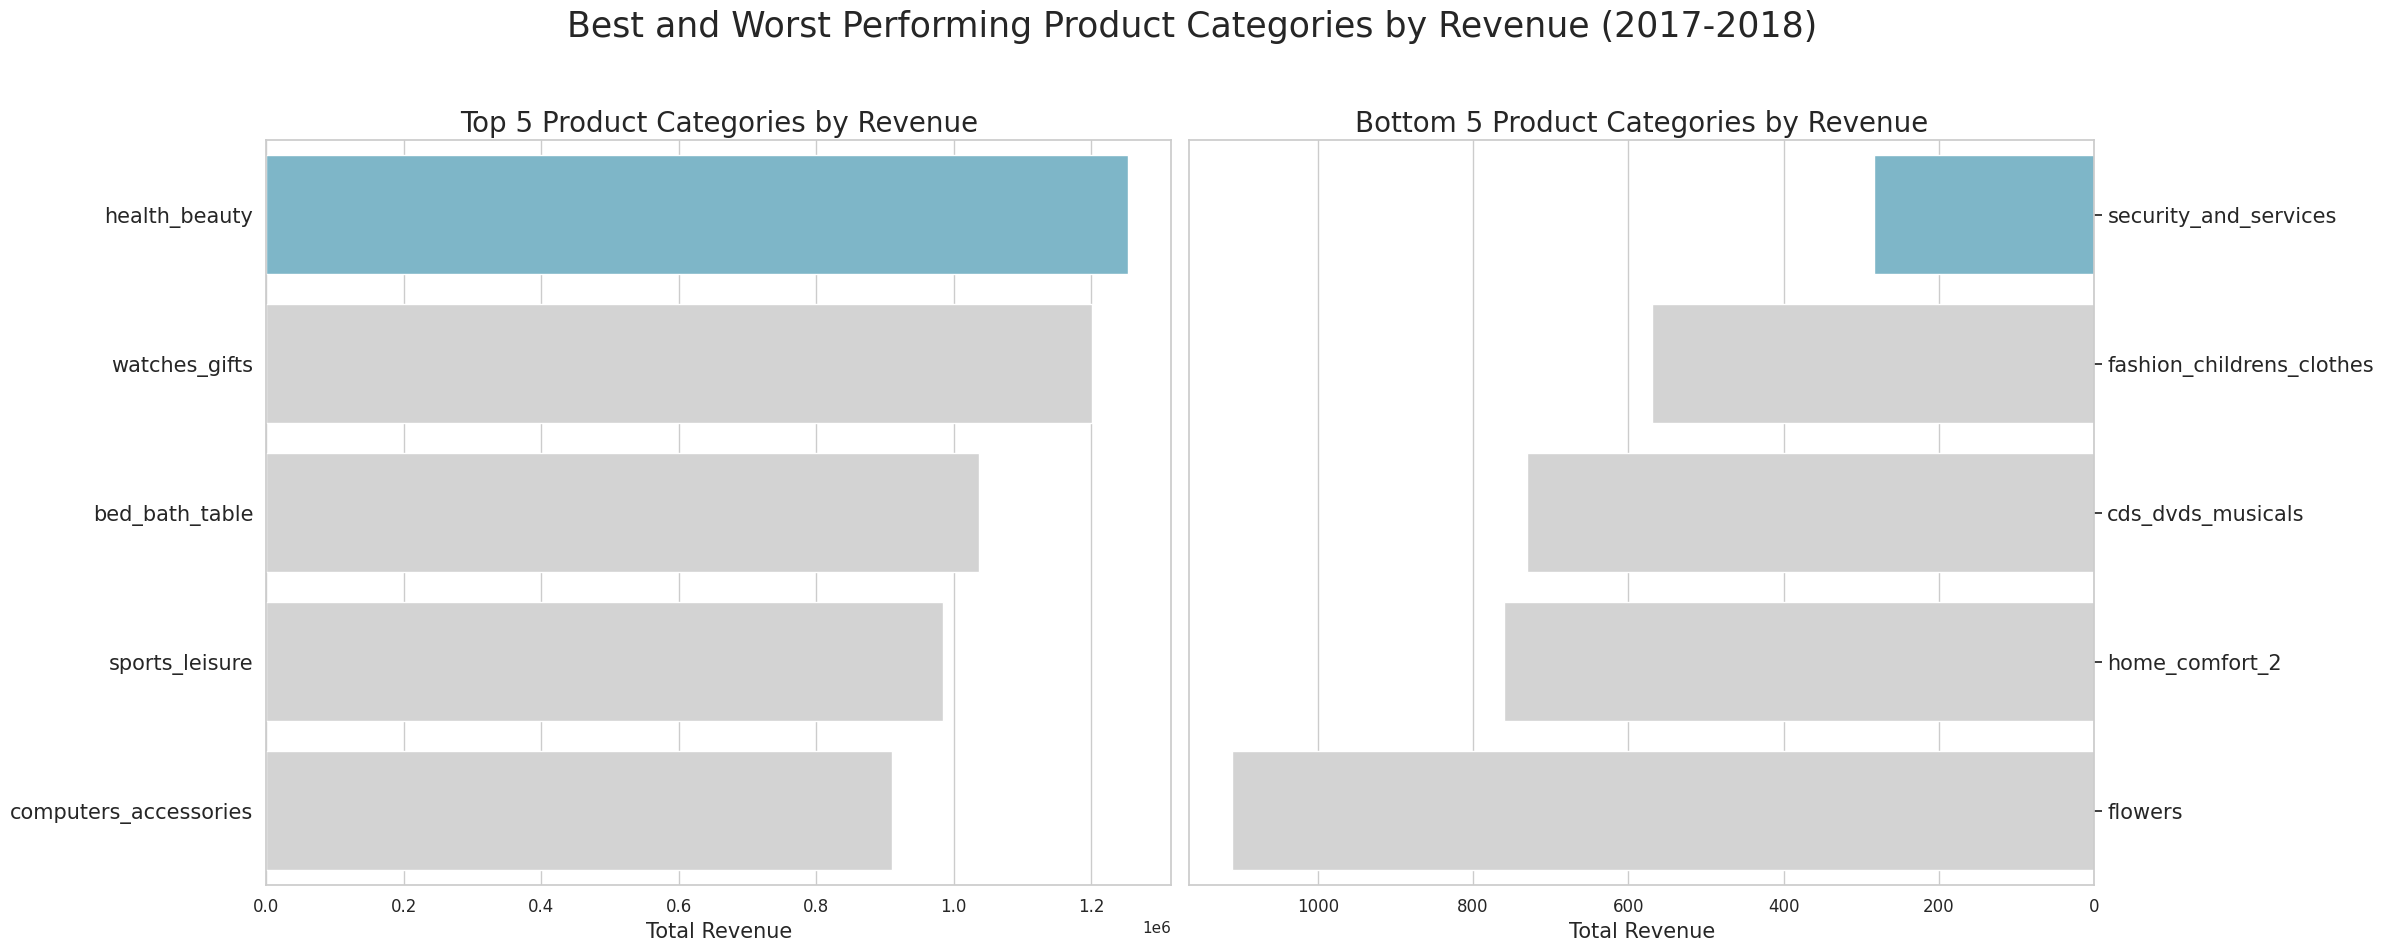

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style seaborn
sns.set_style("whitegrid")

# Membuat canvas untuk 2 visualisasi (Best & Worst)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(24, 10))

# Warna: Biru cerah untuk highlight, Abu-abu untuk lainnya
colors = ["#72BCD4", "#D3D3D3", "#D3D3D3", "#D3D3D3", "#D3D3D3"]

# --- Grafik 1: Kategori Produk dengan Revenue Tertinggi ---
sns.barplot(
    x="price",
    y="product_category_name_english",
    data=category_revenue_df.head(5),
    palette=colors,
    hue="product_category_name_english", # Menghilangkan FutureWarning
    legend=False,
    ax=ax[0]
)
ax[0].set_ylabel(None)
ax[0].set_xlabel("Total Revenue", fontsize=15)
ax[0].set_title("Top 5 Product Categories by Revenue", loc="center", fontsize=20)
ax[0].tick_params(axis ='y', labelsize=15)
ax[0].tick_params(axis ='x', labelsize=12)

# --- Grafik 2: Kategori Produk dengan Revenue Terendah ---
# Kita sort ascending (dari yang terkecil)
sns.barplot(
    x="price",
    y="product_category_name_english",
    data=category_revenue_df.sort_values(by="price", ascending=True).head(5),
    palette=colors,
    hue="product_category_name_english", # Menghilangkan FutureWarning
    legend=False,
    ax=ax[1]
)
ax[1].set_ylabel(None)
ax[1].set_xlabel("Total Revenue", fontsize=15)
ax[1].invert_xaxis() # Membalik axis agar terlihat kontras dengan grafik kiri
ax[1].yaxis.set_label_position("right")
ax[1].yaxis.tick_right()
ax[1].set_title("Bottom 5 Product Categories by Revenue", loc="center", fontsize=20)
ax[1].tick_params(axis='y', labelsize=15)
ax[1].tick_params(axis='x', labelsize=12)

# Judul Utama
plt.suptitle("Best and Worst Performing Product Categories by Revenue (2017-2018)", fontsize=25)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Memberikan ruang agar judul tidak tertutup
plt.show()

**Insight:**
- Kategori health_beauty merupakan penyumbang pendapatan terbesar (Revenue Leader), diikuti oleh watches_gifts dan bed_bath_table. Ketiga kategori ini berhasil menembus angka penjualan di atas 1 juta, menunjukkan bahwa fokus pasar pada platform ini adalah produk gaya hidup dan kebutuhan rumah tangga.
- Terdapat kesenjangan yang sangat ekstrem antara kategori teratas dan terbawah. Kategori security_and_services dan fashion_childrens_clothes memiliki pendapatan yang sangat rendah. Hal ini bisa menjadi indikasi bagi tim Business Development untuk mengevaluasi ketersediaan produk (stock) atau melakukan kampanye khusus pada kategori tersebut jika memang ingin ditingkatkan.
- Perusahaan disarankan untuk menjaga ketersediaan stok pada kategori Top 5 agar tidak terjadi lost sales, serta mempertimbangkan untuk mengurangi biaya operasional pada kategori Bottom 5 yang tidak menguntungkan.


### Pertanyaan 2:

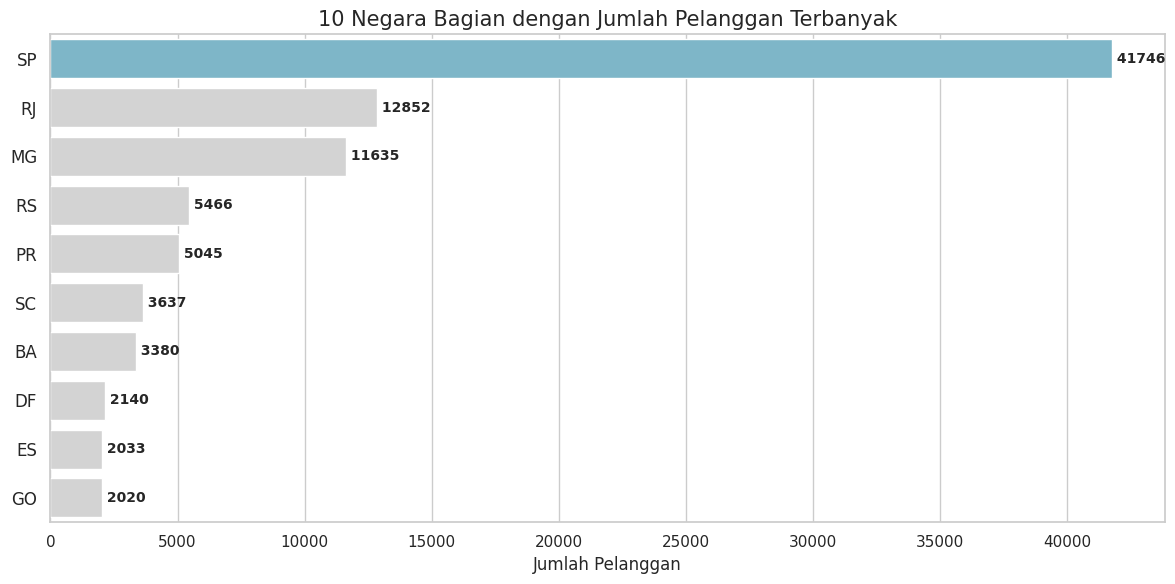

In [57]:
# Menyiapkan data 10 negara bagian teratas
top_10_states = bystate_df.head(10)

# Membuat canvas
plt.figure(figsize=(12, 6))

# Menentukan warna: Biru cerah untuk peringkat pertama, abu-abu untuk sisanya
colors = ["#72BCD4"] + ["#D3D3D3"] * 9

# Membuat bar chart
sns.barplot(
    x="customer_count",
    y="customer_state",
    data=top_10_states,
    palette=colors,
    hue="customer_state", # Menghindari FutureWarning
    legend=False
)

# Menambahkan judul dan label
plt.title("10 Negara Bagian dengan Jumlah Pelanggan Terbanyak", loc="center", fontsize=15)
plt.ylabel(None)
plt.xlabel("Jumlah Pelanggan", fontsize=12)
plt.tick_params(axis='y', labelsize=12)

# Menambahkan label angka di ujung setiap bar agar lebih informatif
for index, value in enumerate(top_10_states['customer_count']):
    plt.text(value, index, f' {value}', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

**Insight:**
- Grafik menunjukkan bahwa negara bagian SP (Sao Paulo) adalah basis pelanggan terbesar dengan 41.746 pelanggan. Jumlah ini sangat kontras dan jauh melampaui wilayah lainnya seperti RJ (Rio de Janeiro) dan MG (Minas Gerais).
- Hal ini mengindikasikan bahwa aktivitas e-commerce masih sangat terpusat di wilayah tenggara Brasil, yang merupakan pusat ekonomi negara tersebut.
- Perusahaan sebaiknya memprioritaskan peningkatan infrastruktur pengiriman di wilayah SP untuk menjaga kepuasan mayoritas pelanggan.
- Terdapat peluang besar untuk melakukan penetrasi pasar di wilayah luar SP (seperti RJ dan MG) melalui kampanye iklan bertarget guna mengurangi ketergantungan hanya pada satu wilayah saja.

## Analisis Lanjutan (Opsional)

### Analisis Lanjutan: RFM Analysis

In [58]:
# Menentukan tanggal referensi (satu hari setelah tanggal transaksi terakhir di dataset)
current_date = main_df['order_purchase_timestamp'].max() + pd.Timedelta(days=1)

# Menghitung Recency, Frequency, dan Monetary
rfm_df = main_df.groupby(by="customer_unique_id", as_index=False).agg({
    "order_purchase_timestamp": lambda x: (current_date - x.max()).days, # Recency
    "order_id": "nunique", # Frequency
    "price": "sum" # Monetary
})

# Mengganti nama kolom
rfm_df.columns = ["customer_id", "recency", "frequency", "monetary"]

# Menampilkan 5 data teratas
rfm_df.head()

,customer_id,recency,frequency,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,161,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,164,1,18.90
2,0000f46a3911fa3c0805444483337064,586,1,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,370,1,25.99
4,0004aac84e0df4da2b147fca70cf8255,337,1,180.00


###Visualization: RFM

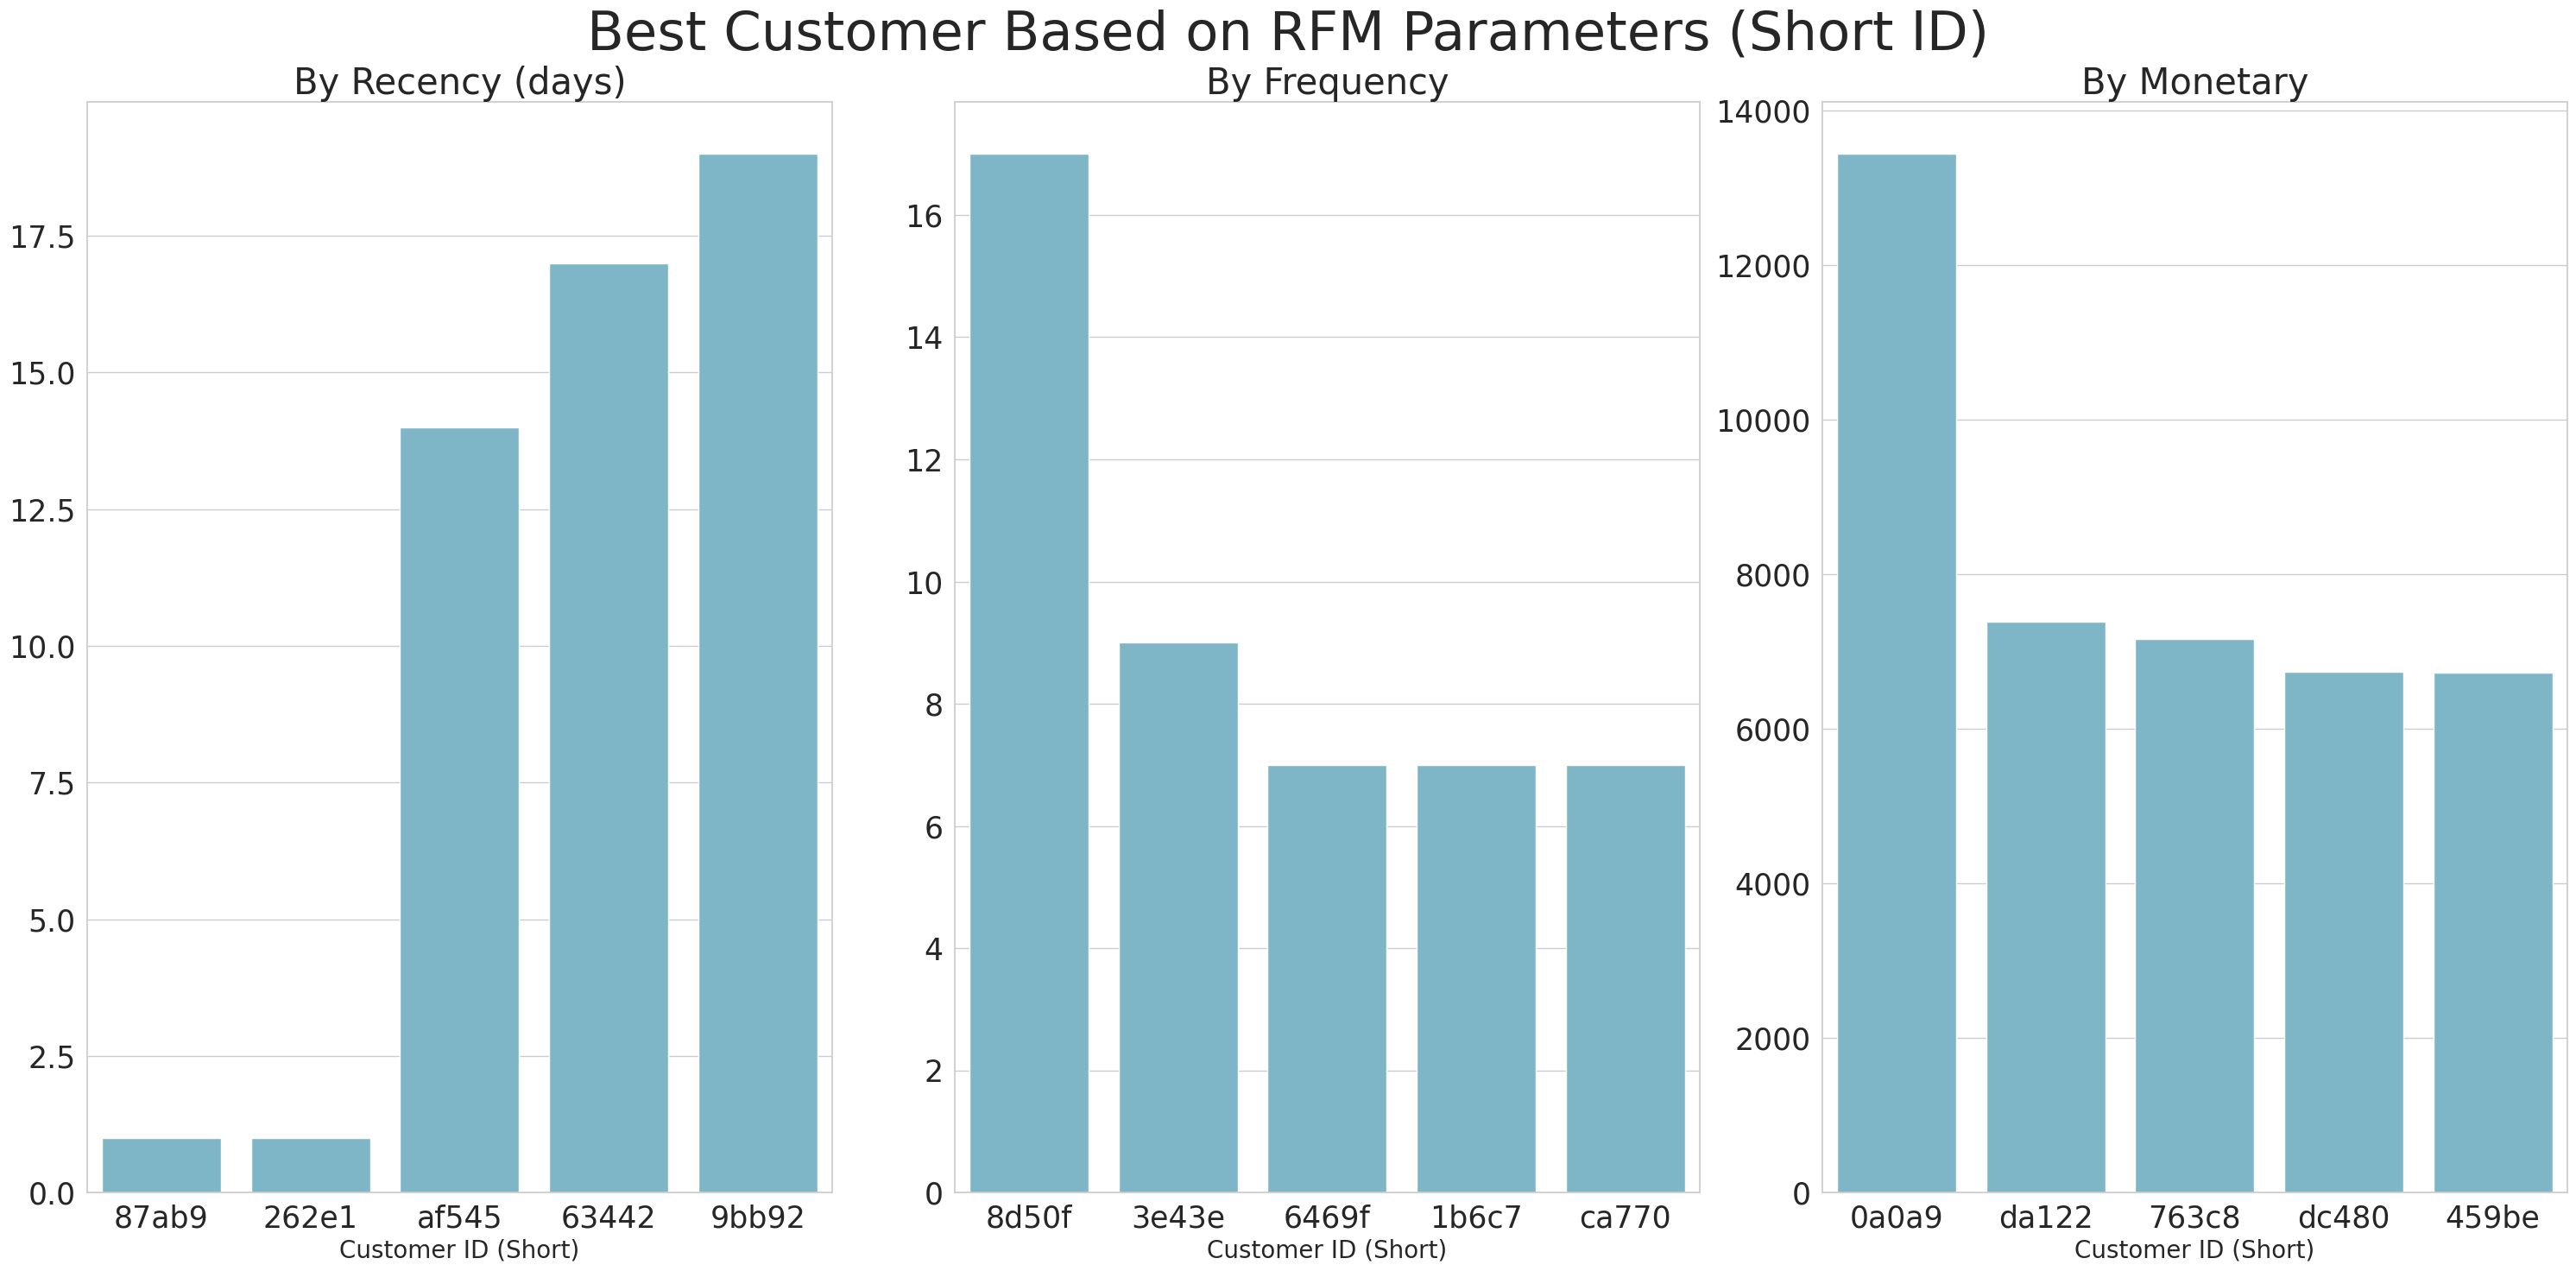

In [59]:
# Membuat canvas
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(30, 15))
colors = ["#72BCD4", "#72BCD4", "#72BCD4", "#72BCD4", "#72BCD4"]

# --- 1. Berdasarkan Recency ---
# Kita ambil 5 karakter pertama dari ID agar tidak berantakan
rfm_recency = rfm_df.sort_values(by="recency", ascending=True).head(5)
rfm_recency['customer_id_short'] = rfm_recency['customer_id'].str[:5]

sns.barplot(y="recency", x="customer_id_short", data=rfm_recency, palette=colors, ax=ax[0], hue="customer_id_short", legend=False)
ax[0].set_ylabel(None)
ax[0].set_xlabel("Customer ID (Short)", fontsize=20)
ax[0].set_title("By Recency (days)", loc="center", fontsize=30)
ax[0].tick_params(axis='y', labelsize=25)
ax[0].tick_params(axis='x', labelsize=25)

# --- 2. Berdasarkan Frequency ---
rfm_frequency = rfm_df.sort_values(by="frequency", ascending=False).head(5)
rfm_frequency['customer_id_short'] = rfm_frequency['customer_id'].str[:5]

sns.barplot(y="frequency", x="customer_id_short", data=rfm_frequency, palette=colors, ax=ax[1], hue="customer_id_short", legend=False)
ax[1].set_ylabel(None)
ax[1].set_xlabel("Customer ID (Short)", fontsize=20)
ax[1].set_title("By Frequency", loc="center", fontsize=30)
ax[1].tick_params(axis='y', labelsize=25)
ax[1].tick_params(axis='x', labelsize=25)

# --- 3. Berdasarkan Monetary ---
rfm_monetary = rfm_df.sort_values(by="monetary", ascending=False).head(5)
rfm_monetary['customer_id_short'] = rfm_monetary['customer_id'].str[:5]

sns.barplot(y="monetary", x="customer_id_short", data=rfm_monetary, palette=colors, ax=ax[2], hue="customer_id_short", legend=False)
ax[2].set_ylabel(None)
ax[2].set_xlabel("Customer ID (Short)", fontsize=20)
ax[2].set_title("By Monetary", loc="center", fontsize=30)
ax[2].tick_params(axis='y', labelsize=25)
ax[2].tick_params(axis='x', labelsize=25)

plt.suptitle("Best Customer Based on RFM Parameters (Short ID)", fontsize=45)
plt.tight_layout()
plt.show()

**Insight:**
- **Recency (Days)**: Loyalitas Terkini: Terdapat pelanggan (ID: 87ab9 dan 262e1) yang memiliki nilai Recency sangat rendah (hampir 0 hari), yang berarti mereka baru saja melakukan transaksi. Sebaliknya, pelanggan seperti ID 9bb92 sudah tidak bertransaksi selama hampir 20 hari. Ini adalah sinyal bagi tim marketing untuk segera memberikan notifikasi atau promo re-engagement agar mereka kembali berbelanja.
- **Frequency**: Pelanggan dengan ID 8d50f menunjukkan aktivitas luar biasa dengan total transaksi mencapai 17 kali. Angka ini jauh melampaui rata-rata pelanggan lainnya yang berada di kisaran 7-9 kali transaksi. Pelanggan di kategori ini adalah kandidat utama untuk program Brand Ambassador atau diberikan akses eksklusif ke produk baru karena tingkat kepercayaan mereka yang sangat tinggi terhadap platform.
- **Monetary**: Dari sisi kontribusi pendapatan, pelanggan ID 0a0a9 merupakan "Whale" atau pelanggan VIP dengan total pengeluaran mencapai lebih dari 13.000. Nilai ini hampir dua kali lipat dibanding pelanggan top spender lainnya di urutan berikutnya yang berada di kisaran 7.000. Perlakuan khusus seperti layanan pelanggan prioritas atau bebas ongkir tanpa syarat sangat disarankan untuk menjaga retensi kelompok pelanggan bernilai tinggi ini.

### Analysis Lanjutan: Geospatial Analysis Distribusi Pelanggan

In [60]:
# Menghitung jumlah pelanggan unik per negara bagian (state)
bystate_df = main_df.groupby(by="customer_state").customer_id.nunique().sort_values(ascending=False).reset_index()
bystate_df.rename(columns={"customer_id": "customer_count"}, inplace=True)

# Menampilkan 10 besar wilayah
print(bystate_df.head(10))

  customer_state  customer_count
0             SP           41746
1             RJ           12852
2             MG           11635
3             RS            5466
4             PR            5045
5             SC            3637
6             BA            3380
7             DF            2140
8             ES            2033
9             GO            2020


###Visualization: Geospatial Customer

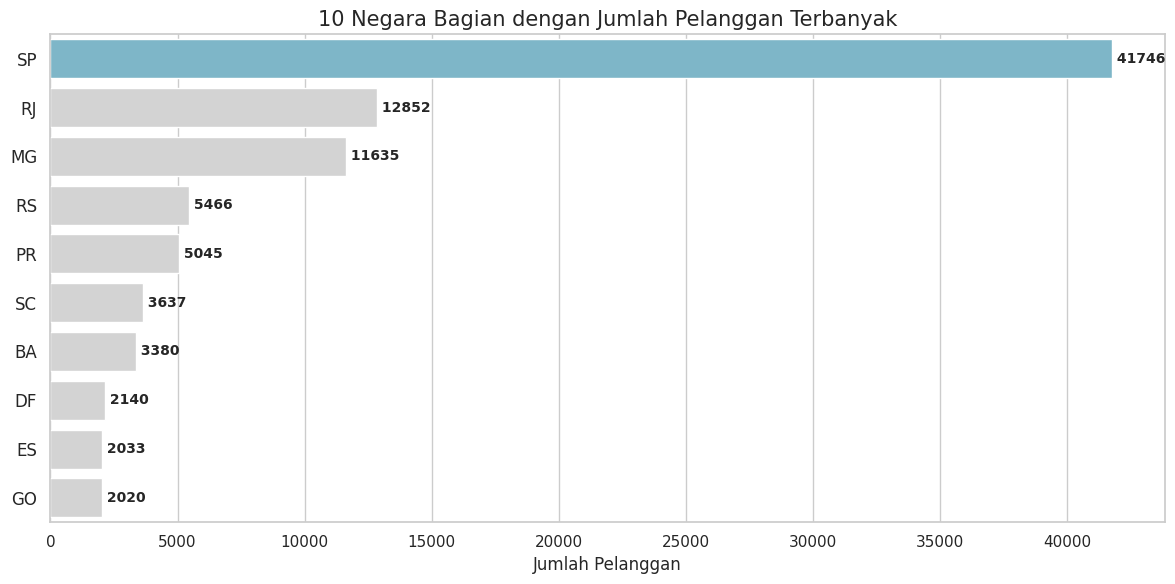

In [61]:
# Menyiapkan data 10 negara bagian teratas
top_10_states = bystate_df.head(10)

# Membuat canvas
plt.figure(figsize=(12, 6))

# Menentukan warna: Biru cerah untuk peringkat pertama, abu-abu untuk sisanya
colors = ["#72BCD4"] + ["#D3D3D3"] * 9

# Membuat bar chart
sns.barplot(
    x="customer_count",
    y="customer_state",
    data=top_10_states,
    palette=colors,
    hue="customer_state", # Menghindari FutureWarning
    legend=False
)

# Menambahkan judul dan label
plt.title("10 Negara Bagian dengan Jumlah Pelanggan Terbanyak", loc="center", fontsize=15)
plt.ylabel(None)
plt.xlabel("Jumlah Pelanggan", fontsize=12)
plt.tick_params(axis='y', labelsize=12)

# Menambahkan label angka di ujung setiap bar agar lebih informatif
for index, value in enumerate(top_10_states['customer_count']):
    plt.text(value, index, f' {value}', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

**Insight:**
- Grafik menunjukkan bahwa negara bagian SP (Sao Paulo) adalah basis pelanggan terbesar dengan 41.746 pelanggan. Jumlah ini sangat kontras dan jauh melampaui wilayah lainnya seperti RJ (Rio de Janeiro) dan MG (Minas Gerais).
- Hal ini mengindikasikan bahwa aktivitas e-commerce masih sangat terpusat di wilayah tenggara Brasil, yang merupakan pusat ekonomi negara tersebut.
- Perusahaan sebaiknya memprioritaskan peningkatan infrastruktur pengiriman di wilayah SP untuk menjaga kepuasan mayoritas pelanggan.
- Terdapat peluang besar untuk melakukan penetrasi pasar di wilayah luar SP (seperti RJ dan MG) melalui kampanye iklan bertarget guna mengurangi ketergantungan hanya pada satu wilayah saja.

### Analisis Lanjutan: Customer Loyalty Clustering

In [62]:
# Membuat kriteria clustering manual berdasarkan frekuensi pembelian
def loyalty_grouping(frequency):
    if frequency == 1:
        return "One-time Buyer"
    elif 2 <= frequency <= 5:
        return "Repeat Customer"
    else:
        return "Loyalist"

# Menerapkan fungsi ke rfm_df
rfm_df['loyalty_cluster'] = rfm_df['frequency'].apply(loyalty_grouping)

# Menghitung jumlah pelanggan di setiap cluster
loyalty_counts = rfm_df['loyalty_cluster'].value_counts().reset_index()
loyalty_counts.columns = ['loyalty_cluster', 'customer_count']

print(loyalty_counts)

   loyalty_cluster  customer_count
0   One-time Buyer           93099
1  Repeat Customer            2986
2         Loyalist              11


###Visualization: Customer Loyalty Segmentation

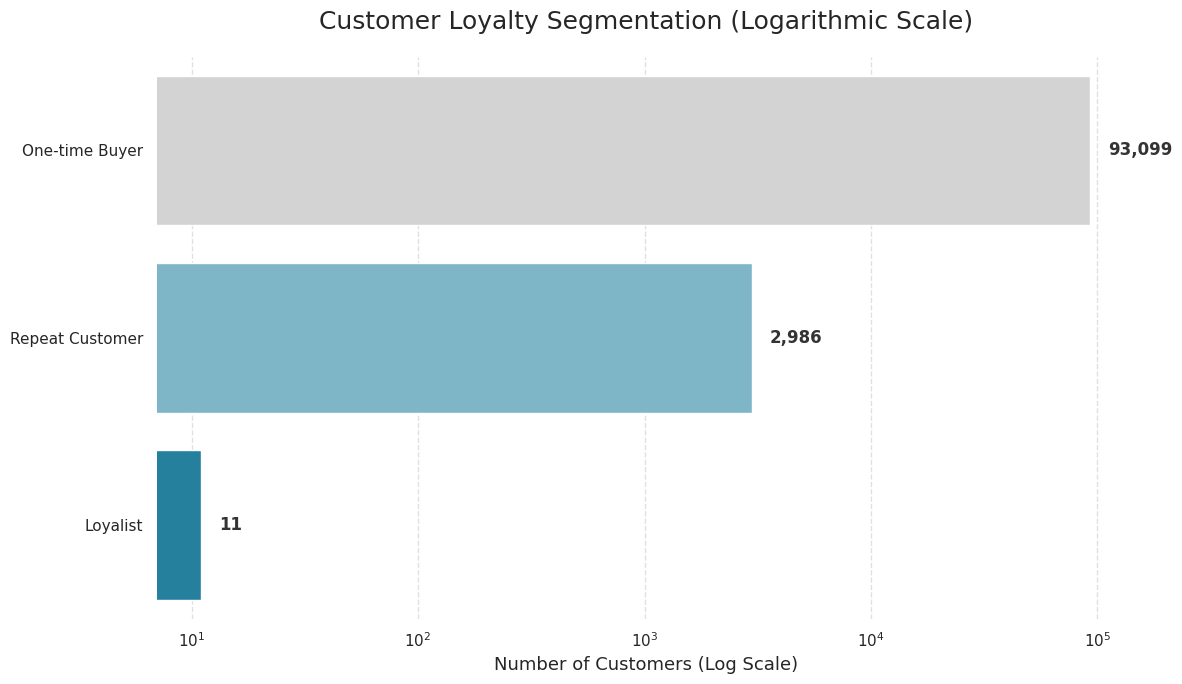

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns

# Menyiapkan data
loyalty_data = {
    'loyalty_cluster': ['One-time Buyer', 'Repeat Customer', 'Loyalist'],
    'customer_count': [93099, 2986, 11]
}
loyalty_df = pd.DataFrame(loyalty_data)

# Membuat canvas
plt.figure(figsize=(12, 7))
colors = ["#D3D3D3", "#72BCD4", "#118AB2"] # Abu-abu untuk mayoritas, Biru untuk yang berharga

# Membuat bar chart dengan Log Scale agar angka 11 tetap terlihat proporsional
ax = sns.barplot(
    x="customer_count",
    y="loyalty_cluster",
    data=loyalty_df,
    palette=colors,
    hue="loyalty_cluster",
    legend=False
)

# Menggunakan skala logaritmik pada sumbu X
plt.xscale('log')

# Menambahkan label angka asli di ujung bar
for i, v in enumerate(loyalty_df['customer_count']):
    ax.text(v * 1.2, i, f'{v:,}', va='center', fontsize=12, fontweight='bold', color='#333333')

# Menghilangkan garis tepi agar lebih clean
sns.despine(left=True, bottom=True)

plt.title("Customer Loyalty Segmentation (Logarithmic Scale)", fontsize=18, pad=20)
plt.xlabel("Number of Customers (Log Scale)", fontsize=13)
plt.ylabel(None)
plt.grid(axis='x', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

**Insight:**
- Sebesar 96,8% pelanggan hanya melakukan satu kali transaksi. Hal ini menunjukkan bahwa platform memiliki kemampuan akuisisi pelanggan yang sangat kuat, namun memiliki tantangan besar dalam hal Customer Retention (mempertahankan pelanggan).
- Terdapat 2.986 pelanggan yang sudah mulai menunjukkan loyalitas dengan berbelanja 2-5 kali. Kelompok ini adalah target paling potensial untuk dikonversi menjadi Loyalist melalui program poin atau promo khusus.
- Hanya ada 11 pelanggan yang masuk kategori Loyalist (belanja >5 kali). Angka ini sangat kecil namun sangat berharga. Perusahaan perlu melakukan wawancara atau survei mendalam kepada 11 orang ini untuk memahami apa yang membuat mereka begitu setia, lalu menduplikasi pola tersebut ke pelanggan lain.
- Fokus utama ke depan bukan lagi sekadar mencari pelanggan baru, melainkan membangun strategi CRM (Customer Relationship Management) untuk mendorong One-time Buyers melakukan pembelian kedua. Peningkatan retensi sebesar 5% saja dapat meningkatkan keuntungan secara signifikan.

## Conclusion

- **Conclution pertanyaan 1: Performa Kategori Produk (2017-2018)**

Berdasarkan analisis pendapatan, kategori produk health_beauty menjadi penyumbang revenue tertinggi mencapai 1.253.993,86, disusul oleh kategori gaya hidup dan rumah tangga lainnya seperti watches_gifts dan bed_bath_table. Di sisi lain, kategori security_and_services memiliki performa terendah dengan total pendapatan hanya 283,29.

Strategi: Perusahaan sebaiknya memprioritaskan ketersediaan stok dan kampanye pemasaran pada kategori Top 5 (kesehatan, kecantikan, dan perlengkapan rumah) karena terbukti memiliki permintaan pasar yang masif. Untuk kategori dengan kontribusi di bawah 1.000, perlu dilakukan evaluasi mendalam terkait strategi harga dan variasi produk.
- **Conclution pertanyaan 2: Persebaran Geografis Pelanggan**

Aktivitas transaksi pelanggan sangat terpusat di wilayah Tenggara Brasil, dengan negara bagian SP (Sao Paulo) sebagai kontributor utama sebanyak 41.746 pelanggan. Jumlah ini jauh melampaui wilayah RJ dan MG yang berada di posisi berikutnya.

Strategi: Tingginya konsentrasi di wilayah SP memberikan peluang strategis untuk menempatkan pusat distribusi utama (Warehouse) di wilayah tersebut guna mengoptimalkan biaya logistik dan mempercepat lead time. Sementara itu, wilayah dengan jumlah pelanggan di kisaran 2.000 hingga 5.000 merupakan pasar potensial yang dapat ditingkatkan penetrasinya melalui kampanye pemasaran berbasis lokasi yang lebih agresif.

In [64]:
# Pilih hanya kolom yang dipakai di dashboard saja
columns_to_keep = [
    'order_id',
    'customer_id',
    'customer_unique_id',
    'order_purchase_timestamp',
    'product_category_name_english',
    'price',
    'customer_state'
]
main_df_small = main_df[columns_to_keep]

# Save lagi jadi file baru yang lebih enteng
main_df_small.to_csv("main_data.csv", index=False)